# Lotka-Volterra System

Consider an ecological system involving a predator species and a prey species. We would like to study the population dynamics of this ecosystem. In particular, we are interested in whether one species goes extinct, or both species can coexist at some equilibrium population sizes, or something else.

Let us first model the dynamics of the system. Imagine that the prey species lives on external food sources, such as plants, which are not explicitly modeled. We assume that the prey population by itself has a birth rate $\beta$ and a death rate $\delta$ per capita, just like in the birth-death process we studied before. The net growth rate will be the difference between the birth and death rates. In addition, the prey are being consumed by the predators, which results in its population loss. Since a predation event requires an encounter between a predator and prey, we may assume that the overall consumption rate is proportional to both the predator and prey abundances, just like in the mass action law, with a rate constant given by a "feeding rate", $f$. On the other hand, the predator population will grow at a rate proportional to the consumption rate of prey; we assume a proportionality constant $\eta$, which represents the efficiency of converting the biomass of prey to predators. Finally, we assume a constant per capita death rate of the predator, $d$.

We may represent the processes described above by chemical reactions like we did before in class. Denote the predator and prey by P and Q respectively, we have:
\begin{align}
Q &\xrightarrow{\beta} 2 Q \\
Q &\xrightarrow{\delta} \emptyset \\
Q + P &\xrightarrow{f} (1 + \eta) P \\
P &\xrightarrow{d} \emptyset
\end{align}
The third reaction is central --- it describes the trophic interaction (predation) between the two species. Here $\eta$ is not really a stoichiometric coefficient as it does not have to be an integer. So we will not make stochastic simulations, but only study the rate equations. You should be able to derive:
\begin{align}
\dot{N}_Q &= (\beta - \delta) N_Q - f N_Q N_P \\
\dot{N}_P &= \eta f N_Q N_P - d N_P
\end{align}

For simplicity of notations, let us denote the abundances of the predator and prey by $Y$ and $X$ instead of $N_P$ and $N_Q$, and also let $r \equiv (\beta - \delta)$ and $g \equiv \eta f$. Then our equations become:
\begin{align}
\dot{X} &= r X - f X Y \\
\dot{Y} &= g X Y - d Y
\end{align}
These are known as the "Lotka-Volterra equations".

## Steady states and stability

Let us first find the steady states of the dynamical equations above. They would be solutions to the equations:
\begin{align}
\dot{X} &= X (r - f Y) = 0 \\
\dot{Y} &= Y (g X - d) = 0
\end{align}
We have two such states: $(X^*, Y^*) = (0, 0)$ and $(d/g, r/f)$. The first steady state simply means both species go extinct. The second steady state is where they coexist in equilibrium.

To check the stability of these steady states, we expand $X, Y$ around their equilibrium values, $X = X^* + \delta X$ and $Y = Y^* + \delta Y$. Inserting these into the original dynamical equations and keeping things to first order in the perturbations, we find:
\begin{equation}
\frac{d}{dt} \left( \begin{array}{c} \delta X \\ \delta Y \end{array} \right) = 
\left( \begin{array}{cc} r - f Y^* & -f X^* \\ g Y^* & g X^* -d \end{array} \right)
\left( \begin{array}{c} \delta X \\ \delta Y \end{array} \right)
\equiv \mathbf{J} \cdot \left( \begin{array}{c} \delta X \\ \delta Y \end{array} \right)
\end{equation}
The eigenvalues of the Jacobian matrix $\mathbf{J}$ will determine the stability of the steady states.

We will evaluate the matrix at both steady states and find their eigenvalues. Eigenvalues of a matrix can be numerically computed using the linear algebra module `numpy.linalg`, as follows.

In [1]:
import numpy as np
import scipy.integrate as intgr
import matplotlib.pyplot as plt

In [2]:
r = f = g = d = 1.    # simple values just for illustration

def jac(X, Y):    # calculate Jacobian matrix
    J = np.array([[r-f*Y, -f*X],
                  [g*Y, g*X-d]])
    return J

X0, Y0 = 0, 0    # steady state at (0, 0)
X1, Y1 = d/g, r/f    # the other steady state

for (X,Y) in [(X0,Y0), (X1,Y1)]:
    w, v = np.linalg.eig(jac(X,Y))    # this function calculates all eigenvalues and eigenvectors
    print(f'steady state at {(X, Y)}: eigenvalues = {w}')

steady state at (0, 0): eigenvalues = [ 1. -1.]
steady state at (1.0, 1.0): eigenvalues = [0.+1.j 0.-1.j]


In fact, one can calculate analytically that, for $(X^*, Y^*) = (0, 0)$, the eigenvalues of $\mathbf{M}$ are $\lambda_1 = r > 0$ and $\lambda_2 = -d < 0$. The presence of the positive eigenvalue means this steady state is unstable. Indeed, if both species are absent, then adding a few preys would allow them to start growing.

On the other hand, for $(X^*, Y^*) = (d/g, r/f)$, the eigenvalues are $\lambda = \pm i \sqrt{r d}$. It may look strange that the eigenvalues are *imaginary*; they actually imply that the flow around the steady state is rotating around this point. The absence of a real part in the eigenvalues implies that this point is *neutrally stable*, such that $(X,Y)$ will circle around this point indefinitely (see below). Were there a positive real part, the flow would be spiraling out; or if the real part were negative, then the flow would be spiraling in. We can plot the flow using `streamplot()` as before.

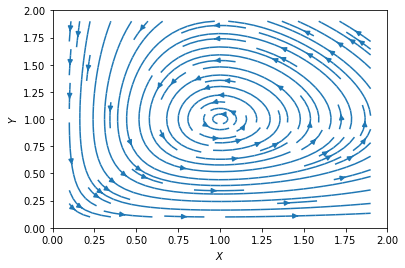

In [3]:
x_points = np.arange(0.1, 2., 0.2)    # grid lines for x-axis
y_points = np.arange(0.1, 2., 0.2)    # grid lines for y-axis
x_grid, y_grid = np.meshgrid(x_points, y_points)    # generate a grid of x, y values

x_flow = x_grid * (r - f * y_grid)
y_flow = y_grid * (g * x_grid - d)

plt.figure()
plt.streamplot(x_grid, y_grid, x_flow, y_flow)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

## Closed orbits and oscillations

Let us visualize the population dynamics by plotting the trajectories in the $X$-$Y$ plane. As before, we will have to numerically solve the dynamical equations. We will define a Python class for the simulation, so that we can easily change parameters and initial values later. You will notice that the class below is written very similarly to the `RateEquations` class we had before. The main difference is in the `equations()`.

In [4]:
class LotkaVolterra:
    """
    simulating the Lotka-Volterra system.
    """
    
    def __init__(self, param, init, record=True):
        """
        initialize by assigning parameter values and initial values.
        inputs:
        param: list, parameters of the model: r, f, c, d (in this order)
        init: list, initial abundance of prey and predator species (in this order)
        record: boolean, whether to record history of abundances at time points
        """
        self.param = param    # list of parameters
        self.abundance = np.asarray(init)    # current abundance of each species
        self.time = 0.                  # time since beginning of simulation
        self.record = record            # whether to record time series
        if self.record:
            self.time_hist = [0.]                  # list of time points
            self.abundance_hist = [self.abundance.copy()]     # list of abundances at time points
    
    def equations(self, x, t):
        """
        calculate time derivatives of abundances in the Lotka-Volterra system.
        inputs:
        x: 1-d array, current abundances of both species.
        t: float, current time.
        outputs:
        dxdt: 1-d array, time derivatives of abundances.
        """
        X, Y = x    # parse variables, X is prey and Y is predator
        dXdt = self.param[0] * X - self.param[1] * X * Y
        dYdt = self.param[2] * X * Y - self.param[3] * Y
        return [dXdt, dYdt]
    
    def run(self, tmax, dt):
        """
        solve equations until time `tmax` since the beginning of the simulation.
        inputs:
        tmax: float, time since the beginning of the simulation.
        dt: float, time step by which solution is calculated
        """
        T = tmax - self.time    # time remaining to be solved
        new_times = np.arange(0, T+dt, dt)    # new time points at every step dt
        x0 = self.abundance    # current abundances as initial values to the solver
        sol = intgr.odeint(self.equations, x0, new_times)    # solve equations using integrator
        if self.record:
            self.time_hist.extend(self.time + new_times[1:])    # save time points
            self.abundance_hist.extend(sol[1:])    # save abundances at given time points
        self.time += new_times[-1]    # update time to latest
        self.abundance = sol[-1]    # update abundances to latest

Let us choose some appropriate parameter values. Without loss of generality, we can set $d = 1$ by rescaling time. Similarly, by using $X^* = d/g$ and $Y^* = r/f$ as units for the population sizes $X$ and $Y$, we effectively set $X^* = Y^* = 1$, which then means $g = 1$ and $f = r$. Therefore, we are left with only one free parameter, $r$, which controls the growth rate of the prey relative to the lifespan of the predator, i.e., the "turnover" rate. Consider the case of a large $r$, e.g., $r=5$, so that the prey grows fast and there is plenty food for the predator.

In [5]:
r = 5    # growth rate of the prey
f = r    # feeding rate of the predator
g = 1    # growth rate of the predator per prey available
d = 1    # death rate of the predator

T = 10.    # total time to integrate the trajectories
dt = 0.01   # time steps to evaluate the trajectories at

X0, Y0 = np.random.rand(2)    # random initial values between 0 and 1
lv = LotkaVolterra([r, f, g, d], [X0, Y0])
lv.run(T, dt)
print(f'current time = {lv.time}, current populations = {lv.abundance}')

current time = 10.0, current populations = [0.9741404  0.40914513]


If we plot $X$ and $Y$ as functions of time, we will see that they undergo some kind of "nonlinear oscillations".

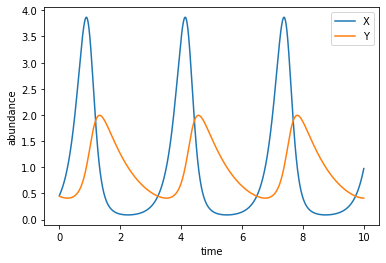

In [6]:
time_hist = lv.time_hist    # time history
num_hist = np.array(lv.abundance_hist)    # abundance history of all species

plt.figure()
plt.plot(time_hist, num_hist[:,0], label='X')    # plot prey abundance vs time
plt.plot(time_hist, num_hist[:,1], label='Y')    # plot predator abundance vs time
plt.xlabel('time')
plt.ylabel('abundance')
plt.legend(loc='upper right')
plt.show()

A heuristic argument goes like: first the prey grows in number, then the predator has more food to eat and grows in number, then the prey is consumed fast and reduces in number, then the predator runs out of food and reduces in number, and finally the prey gets a chance to grow again, and so on. The main point is that neither population settles onto an equilibrium value. Indeed, the predator-prey model was historically used to illustrate that, in nature, the dynamics of populations (as many other things in biology) do not have to reach an equilibrium state.

Let us run the simulation multiple times, and plot the trajectories in the phase space (X-Y plane).

In [7]:
num = 10    # number of trajectories to simulate
lv_list = []    # list of simulations with different initial values

for i in range(num):
    X0, Y0 = np.random.rand(2)    # random initial values between 0 and 1
    lv = LotkaVolterra([r, f, g, d], [X0, Y0])
    lv.run(T, dt)
    print(f'current time = {lv.time}, current populations = {lv.abundance}')
    lv_list.append(lv)

current time = 10.0, current populations = [1.16098739 1.31622079]
current time = 10.0, current populations = [0.10108912 0.63875512]
current time = 10.0, current populations = [0.90350065 0.36854218]
current time = 10.0, current populations = [0.02361728 1.93205747]
current time = 10.0, current populations = [1.84411958 1.38471389]
current time = 10.0, current populations = [0.02378507 0.72741858]
current time = 10.0, current populations = [9.7665736  1.14305527]
current time = 10.0, current populations = [8.38454742 0.64276834]
current time = 10.0, current populations = [0.99211186 1.25093108]
current time = 10.0, current populations = [0.02089249 1.14245964]


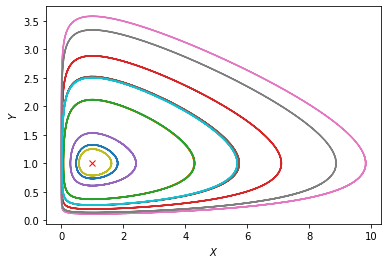

In [8]:
plt.figure()
for lv in lv_list:
    time_hist = lv.time_hist    # time history
    num_hist = np.array(lv.abundance_hist)    # abundance history of all species
    plt.plot(num_hist[:,0], num_hist[:,1])    # plot prey vs predator abundances
plt.plot([X1], [Y1], 'rx')    # plot the neutrally stable steady state
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

We see a collection of closed orbits going around the neutrally stable point $(X^*, Y^*)$. Notice from the previous plot that the phase of $Y(t)$ is behind that of $X(t)$, which means that the closed orbits go in the counterclockwise direction.

The existence of closed orbits in a dynamical system is a nontrivial result. Here we even have a family of closed orbits as the distance from the neutrally stable point varies. This is in fact because the particular equations of the Lotka-Volterra system have a symmetry that leads to a conservation law, like in classical mechanics. The conserved quantity (or "integral of motion") here is $I = g x - d \log(x) + f y - r \log(y)$.

**Exercise**: Check that $dI/dt = 0$ using the dynamical equations.

## Limit Cycle

The closed orbits found above share one property in common with the steady states. Once the system is on a particular orbit, it never leaves the orbit. This is similar to a steady state, as once the system is at a particular steady state, it never leaves there. For steady states, we studied their stability, i.e., given a small perturbation away from the steady state, whether the system will return to it. We can ask a similar question for the closed orbits, i.e., if the system is perturbed away from an orbit, will it settle back on it.

This is not true for the simple model above. As we have seen, there is a family of closed orbits around the steady state $(X^*, Y^*)$, distinguished by their distance from the steady state. If we push the system a little bit off one orbit to a nearby point, it will simply settle on another orbit that passes through the new point. Therefore, under perturbations, the system will drift from one orbit to another, instead of staying close to a particular orbit.

However, small modifications of the original Lotka-Volterra equations would lead to a different behavior. To motivate the modifications, notice that in the original model, the constant per capita growth rate of the prey means that the prey abundance can grow exponentially and indefinitely in the absence of the predator. In reality, there is limited amount of resources that can only support a finite population size. To address this problem, we may introduce *competition* between the prey individuals (recall the birth-death-competition process in [homework3](../Unit3-Stochastic-Processes/homework3.ipynb)). This will amount to changing the overall growth rate of the prey abundance from $r X$ to $r X \cdot (1-X/C)$, where the new parameter $C$ represents the "carrying capacity" for the prey. The factor $(1-X/C)$ guarantees that the growth rate reduces to $0$ when $X$ approaches $C$, so that the prey abundance can never exceed the carrying capacity.

Similarly, consider the consumption rate of the prey by the predator. We assumed above that the overall consumption rate is proportional to both the predator and prey abundances. That means if the prey abundance becomes very large somehow, the consumption rate may in principle increase without bound (besides the limit coming from the carrying capacity above). This is not realistic, because beyond a certain point the predators would be "satiated", unable to consume the prey any faster. Therefore, let us modify the consumption rate from $f X Y$ to $f X Y \cdot K/(X+K)$. The new factor $K/(X+K)$ makes sure that, when $X$ is large, the consumption rate saturates at a level $f K Y$; on the other hand, when $X$ is small, the factor goes to $1$ and we recover $f X Y$. This modified consumption rate is called a "type II functional response" in ecology, whereas the original mass-action form is called "type I". The new parameter $K$ can be viewed as the "consumption capacity" for the prey by the predator.

After these modifications, our dynamical equations become:
\begin{align}
\dot{X} &= r X \Big( 1 - \frac{X}{C} \Big) - f X Y \Big( \frac{K}{X + K} \Big) \\
\dot{Y} &= g X Y \Big( \frac{K}{X + K} \Big) - d Y
\end{align}

To simulate the modified model, we can define a derived class of the original `LotkaVolterra` class. All we need is to decorate the `equations()` method.

In [9]:
class ModifiedLotkaVolterra(LotkaVolterra):
    """
    modify the predator-prey model by adding prey carrying capacity and predator satiation.
    """
    
    def equations(self, x, t):    # replacing the equations of the base class
        """
        calculate time derivatives of abundances in modified Lotka-Volterra equations.
        inputs:
        x: 1-d array, current abundances of both species.
        t: float, current time.
        outputs:
        dxdt: 1-d array, time derivatives of abundances.
        """
        X, Y = x    # parse variables, X is prey and Y is predator
        factor1 = (1 - X / self.param[4])    # param[4] is C
        factor2 = (self.param[5] / (X + self.param[5]))    # param[5] is K
        dXdt = self.param[0] * X * factor1 - self.param[1] * X * Y * factor2
        dYdt = self.param[2] * X * Y * factor2 - self.param[3] * Y
        return [dXdt, dYdt]

Note that we now have two new parameters $C$ and $K$. The new behavior that we will look for happens when $K > d/g$ and $C > K(gK+d)/(gK-d)$. Let us run some simulations with parameters in that range.

In [10]:
C = 8    # carrying capacity
K = 3    # consumption capacity

T = 20.    # total time to integrate the trajectories
dt = 0.01   # time steps to evaluate the trajectories at

num = 10    # number of trajectories to simulate
mlv_list = []    # list of simulations with different initial values

for i in range(num):
    X0, Y0 = np.random.rand(2)    # random initial values between 0 and 1
    mlv = ModifiedLotkaVolterra([r, f, g, d, C, K], [X0, Y0])
    mlv.run(T, dt)
    print(f'current time = {mlv.time}, current populations = {mlv.abundance}')
    mlv_list.append(mlv)

current time = 20.01, current populations = [2.95975025 0.49488357]
current time = 20.01, current populations = [0.1576071  0.86732205]
current time = 20.01, current populations = [4.47094092 0.59637233]
current time = 20.01, current populations = [4.8468879  1.31874527]
current time = 20.01, current populations = [4.60225864 0.61106926]
current time = 20.01, current populations = [0.80699131 0.48018203]
current time = 20.01, current populations = [4.84761065 0.64414391]
current time = 20.01, current populations = [5.28971701 1.09493367]
current time = 20.01, current populations = [0.16641022 0.82357656]
current time = 20.01, current populations = [0.16565913 1.26570262]


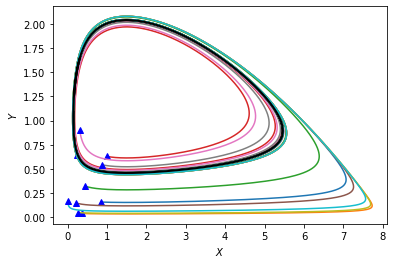

In [11]:
plt.figure()
for mlv in mlv_list:
    time_hist = mlv.time_hist    # time history
    num_hist = np.array(mlv.abundance_hist)    # abundance history of all species
    plt.plot(num_hist[:,0], num_hist[:,1])    # plot prey vs predator abundances
    plt.plot([num_hist[0,0]], [num_hist[0,1]], 'b^')    # blue trianble labels starting point of each trajectory
    plt.plot(num_hist[-500:,0], num_hist[-500:,1], 'k', lw=2)    # black line labels last period of each trajectory
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

We see that all trajectories converge to a single closed orbit, marked black in the above figure. If a trajectory starts outside that orbit, it will spiral inward and asymptotically approach the orbit from outside. And if a trajectory starts inside that orbit, it will spiral outward and asymptotically approach the orbit from inside. Such an isolated closed orbit (i.e., having no other closed orbits in its neighborhood) is called a "limit cycle". What we have here is a *stable* limit cycle because it "attracts" nearby trajectories. (One could also have unstable limit cycles from which a small perturbation leads to the trajectory spiraling away.)

Steady states and limit cycles are common features of dynamical systems. They share the property that once the system is on such a state or trajectory, it will remain so indefinitely. Stable steady states and limit cycles both belong to a class of objects called "attractors" in dynamical systems.